# Time Series Forecasting using RNN

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

### Functions used for processing/preparing the data

## Dataset -  Daily minimum temperatures in Melbourne from 1981 to 1990 

In [ ]:
dailyTemps = pd.read_csv("daily-minimum-temperatures.csv", 
                        parse_dates=[0], index_col=[0])
dailyTemps.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


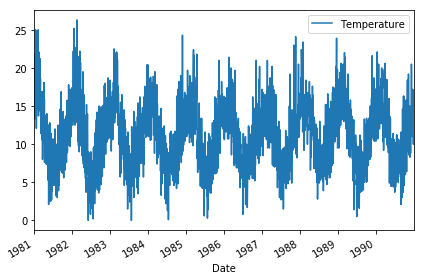

In [ ]:
dailyTemps.plot(figsize=(6,4))
plt.tight_layout()
plt.show()

### Based on previous 7 days minimum temperature, predict the minimum temperature after two days

In [ ]:
def createDelayedColumns(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

def convert3D(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)



In [ ]:
previousDays = 7
afterDays = 2

X = createDelayedColumns(dailyTemps, 
        times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(dailyTemps, 
        times=[afterDays]).iloc[previousDays:-afterDays]

print(X.head())
print(y.head())

print(X.shape)
print(y.shape)

                   t-6         t-5         t-4         t-3         t-2  \
           Temperature Temperature Temperature Temperature Temperature   
Date                                                                     
1981-01-08        17.9        18.8        14.6        15.8        15.8   
1981-01-09        18.8        14.6        15.8        15.8        15.8   
1981-01-10        14.6        15.8        15.8        15.8        17.4   
1981-01-11        15.8        15.8        15.8        17.4        21.8   
1981-01-12        15.8        15.8        17.4        21.8        20.0   

                   t-1           t  
           Temperature Temperature  
Date                                
1981-01-08        15.8        17.4  
1981-01-09        17.4        21.8  
1981-01-10        21.8        20.0  
1981-01-11        20.0        16.2  
1981-01-12        16.2        13.3  
                   t+2
           Temperature
Date                  
1981-01-08        20.0
1981-01-09        1

### Now you have X and y, slice them into training and test dataset.

In [ ]:
train_slice = slice(None, '1988-12-28')
test_slice = slice('1989-01-01', None)

Xtrain, Ytrain = X.loc[train_slice], y.loc[train_slice]
Xtest, Ytest = X.loc[test_slice], y.loc[test_slice]

print(Xtrain.shape)
print(Xtest.shape)

(2911, 7)
(728, 7)


### RNN needs 3D input

In [ ]:
Xtrain3D = convert3D(Xtrain)
Xtest3D = convert3D(Xtest)

print(Xtrain3D.shape)
print(Xtest3D.shape)

(2911, 7, 1)
(728, 7, 1)


## Vanilla - Simple RNN

In [ ]:
rnnModel = keras.models.Sequential()

rnnModel.add(keras.layers.SimpleRNN(50, return_sequences=True,
                                    input_shape=(7,1)))

rnnModel.add(keras.layers.SimpleRNN(25))

rnnModel.add(keras.layers.Dense(1))

rnnModel.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 7, 50)             2600      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 25)                1900      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 4,526
Trainable params: 4,526
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

rnnModel.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [ ]:
# train the model

history = rnnModel.fit(Xtrain3D, Ytrain, epochs = 50, batch_size=20, validation_split=0.1, verbose=1 )

Train on 2619 samples, validate on 292 samples
Epoch 1/50
2619/2619 [==============================] - 1s 500us/sample - loss: 42.7366 - mean_absolute_error: 5.2698 - val_loss: 18.9572 - val_mean_absolute_error: 3.4405
Epoch 2/50
2619/2619 [==============================] - 1s 215us/sample - loss: 19.0151 - mean_absolute_error: 3.4286 - val_loss: 12.7089 - val_mean_absolute_error: 2.8224
Epoch 3/50
2619/2619 [==============================] - 1s 212us/sample - loss: 13.2819 - mean_absolute_error: 2.8170 - val_loss: 9.8935 - val_mean_absolute_error: 2.4902
Epoch 4/50
2619/2619 [==============================] - 1s 224us/sample - loss: 10.7903 - mean_absolute_error: 2.5218 - val_loss: 8.9488 - val_mean_absolute_error: 2.3608
Epoch 5/50
2619/2619 [==============================] - 1s 224us/sample - loss: 9.8621 - mean_absolute_error: 2.4116 - val_loss: 9.3311 - val_mean_absolute_error: 2.4148
Epoch 6/50
2619/2619 [==============================] - 1s 221us/sample - loss: 9.4284 - mean_abs

Epoch 49/50
2619/2619 [==============================] - 1s 248us/sample - loss: 8.0457 - mean_absolute_error: 2.2123 - val_loss: 8.2855 - val_mean_absolute_error: 2.2547
Epoch 50/50
2619/2619 [==============================] - 1s 274us/sample - loss: 7.9483 - mean_absolute_error: 2.1942 - val_loss: 8.4841 - val_mean_absolute_error: 2.2994


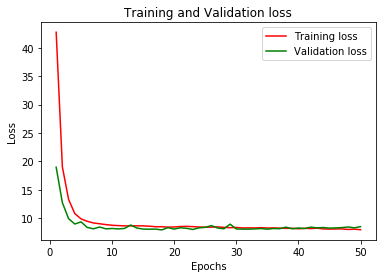

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
testResult = rnnModel.evaluate(Xtest3D, Ytest)
print(testResult)

728/728 [==============================] - 0s 86us/sample - loss: 7.0122 - mean_absolute_error: 2.0661
[7.01219538803939, 2.066066]


In [ ]:
rnnModel.predict(Xtest3D)

array([[14.0329   ],
       [14.912584 ],
       [15.469818 ],
       [15.476652 ],
       [13.231074 ],
       [12.616576 ],
       [13.246525 ],
       [13.804676 ],
       [14.245089 ],
       [13.22929  ],
       [13.04735  ],
       [14.211578 ],
       [14.313802 ],
       [14.712904 ],
       [14.652284 ],
       [15.095653 ],
       [14.87055  ],
       [13.777441 ],
       [15.555595 ],
       [16.404785 ],
       [15.080539 ],
       [15.636372 ],
       [14.344925 ],
       [14.175928 ],
       [14.8556595],
       [14.725327 ],
       [15.287408 ],
       [16.200489 ],
       [16.457422 ],
       [16.140526 ],
       [16.400013 ],
       [16.518476 ],
       [16.001904 ],
       [16.418615 ],
       [15.69806  ],
       [15.22122  ],
       [15.0485735],
       [15.636007 ],
       [15.910372 ],
       [15.481656 ],
       [15.5163355],
       [16.35365  ],
       [16.234688 ],
       [16.482508 ],
       [16.265219 ],
       [16.52852  ],
       [16.584461 ],
       [16.61